In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread
import matplotlib.patches as patches
import pandas as pd
from tqdm import tqdm
import cv2
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from skimage import feature
import pickle
from sklearn.preprocessing import StandardScaler
import random
import pickle
from sklearn.utils import resample

c:\Users\33631\Documents\Etudes\centrale 3A\computer vision\cars_detection\venv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
from cars_detector.utils  import read_test_frame, read_frame
from cars_detector.sampling import sampling
from cars_detector.augmentation import random_augmentation
from cars_detector.features import compute_features, compute_colors_features
from cars_detector.makebox import non_max_suppression, box_otsu
from cars_detector.splitpictures import pyramid
from cars_detector.window_sliding import first_window_sliding, window_sliding_advanced
from cars_detector.hard_negative_sampling import hard_negative_sampling

In [3]:
df_ground_truth = pd.read_csv('train.csv')

## Sampling of positive and negative examples

In [4]:
if os.path.isfile("data/pos_neg_samples/positive_samples.pkl") and os.path.isfile("data/pos_neg_samples/negative_samples.pkl"):
    print('load data')
    total_positive_samples = pickle.load(open('data/pos_neg_samples/positive_samples.pkl', 'rb'))
    total_negative_samples = pickle.load(open('data/pos_neg_samples/negative_samples.pkl', 'rb'))

else:
    total_positive_samples, total_negative_samples = sampling(df_ground_truth)
    pickle.dump(total_negative_samples,open('data/pos_neg_samples/negative_samples.pkl', 'wb'))
    pickle.dump(total_positive_samples,open('data/pos_neg_samples/positive_samples.pkl', 'wb'))
    


100%|██████████| 2225/2225 [00:35<00:00, 62.27it/s]


In [5]:
total_positive_samples = random.sample(total_positive_samples, 8000)
total_negative_samples = random.sample(total_negative_samples, 15000)

## Data Augmentation

In [6]:
new_positive_samples = []
new_negative_samples = []
thresh = 0.2
for img in tqdm(total_positive_samples, position = 0):
    r = np.random.rand(1)
    if r <= thresh:
        new_img = random_augmentation(img)
        new_positive_samples.append(new_img)

total_positive_samples.extend(new_positive_samples)
total_negative_samples.extend(new_negative_samples)

  0%|          | 0/8000 [00:00<?, ?it/s]c:\Users\33631\Documents\Etudes\centrale 3A\computer vision\cars_detection\venv\lib\site-packages\skimage\_shared\utils.py:293: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)
100%|██████████| 8000/8000 [00:00<00:00, 15260.28it/s]


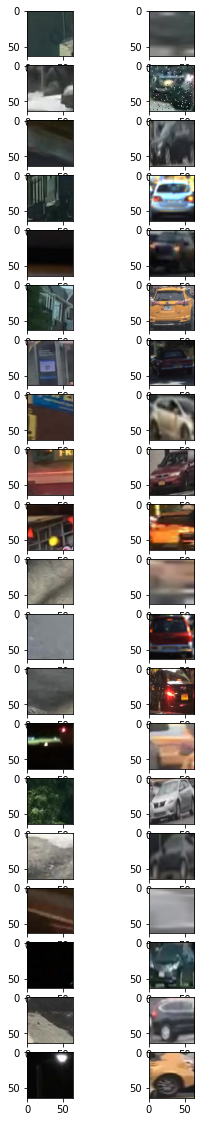

In [7]:
# samples visualisation
number_of_positive_samples = len(total_positive_samples)
number_of_negative_samples = len(total_negative_samples)

fig, ax = plt.subplots(20,2,figsize=(4, 20))
for i in range(20):
    for j in range(2):
        if j == 0:
            img = total_negative_samples[np.random.randint(number_of_negative_samples)]
        else:
            img = total_positive_samples[np.random.randint(number_of_positive_samples)]

        ax[i][j].imshow(img)

In [8]:
print(f"number of positive samples: {len(total_positive_samples)}")
print(f"number of negative samples: {len(total_negative_samples)}")

number of positive samples: 9552
number of negative samples: 15000


## Features computation

In [9]:
if os.path.isfile("data/features/positive_features.pkl") and os.path.isfile("data/features/negative_features.pkl"):
    print('load data')
    positive_features = pickle.load(open("data/features/positive_features.pkl", 'rb'))
    negative_features = pickle.load(open("data/features/negative_features.pkl", 'rb'))
else:
    print('compute features')
    positive_features = []
    for img in tqdm(total_positive_samples, position = 0):
        feat = compute_features(img)
        positive_features.append(feat)
    pickle.dump(positive_features,open("data/features/positive_features.pkl", 'wb'))

    negative_features = []
    for img in tqdm(total_negative_samples, position = 0):
        feat = compute_features(img)
        negative_features.append(feat)
    pickle.dump(positive_features,open("data/features/negative_features.pkl", 'wb'))

compute features


100%|██████████| 15000/15000 [02:12<00:00, 113.62it/s]


In [10]:
from sklearn.model_selection import train_test_split
import gc

if os.path.isfile("data/sets/X_train.pkl"):
    print('load data')
    X_train = pickle.load(open("data/sets/X_train.pkl", 'rb'))
    X_test = pickle.load(open("data/sets/X_test.pkl", 'rb'))
    y_train = pickle.load(open("data/sets/y_train.pkl", 'rb'))
    y_test = pickle.load(open("data/sets/y_test.pkl", 'rb'))

else:
    print("compute sets")
    X = np.concatenate((positive_features,negative_features), axis = 0)
    y = np.array([1 for i in range(len(positive_features))]+[0 for i in range(len(negative_features))])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y, shuffle = True)
    pickle.dump(X_train,open("data/sets/X_train.pkl", 'wb'))
    pickle.dump(X_test,open("data/sets/X_test.pkl", 'wb'))
    pickle.dump(y_train,open("data/sets/y_train.pkl", 'wb'))
    pickle.dump(y_test,open("data/sets/y_test.pkl", 'wb'))
# scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.float32(X_train))
X_test_scaled = scaler.transform(np.float32(X_test))

compute sets


In [11]:
eval_set = [(X_test, y_test)]
if os.path.isfile('data/models/XGB.json'):
    print('load model')
    clf = XGBClassifier(early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set)
    clf.load_model("data/models/XGB.json")
else:
    clf = XGBClassifier(early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set)
    clf.fit(X_train_scaled, y_train)
    clf.save_model("data/models/XGB.json")

y_pred = clf.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
print(f"accuracy: {acc}")

c:\Users\33631\Documents\Etudes\centrale 3A\computer vision\cars_detection\venv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:24:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stopping_rounds", "eval_set" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




c:\Users\33631\Documents\Etudes\centrale 3A\computer vision\cars_detection\venv\lib\site-packages\xgboost\sklearn.py:585: UserWarning: kwargs is not saved in Scikit-Learn meta.
  warnings.warn(str(k) + ' is not saved in Scikit-Learn meta.', UserWarning)


accuracy: 0.9492974954184484


In [12]:
eval_set = [(X_test, y_test)]
if os.path.isfile('data/models/XGB_with_neg_sampling.json'):
    print('load model')
    clf = XGBClassifier(early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set)
    clf.load_model("data/models/XGB_with_neg_sampling.json")
elif os.path.isfile('data/models/XGB.json'):
    print("hard negative sampling !")
    # compute negative samples
    hard_neg_samples = hard_negative_sampling(df_ground_truth, clf, scaler)
    pickle.dump(hard_neg_samples,open("data/pos_neg_samples/hard_neg_samples.pkl", 'wb'))
    # compute features
    hard_neg_samples_features = []
    for sample in hard_neg_samples:
        feat = compute_features(sample)
        hard_neg_samples_features.append(feat)
    # take a smaller sample of X_train and y_train
    X_train, y_train = resample(X_train, y_train, n_samples = np.int32(0.6*len(y_train)), random_state=0, stratify = y_train, replace = False)
    # create the new data set
    X_train = np.concatenate((X_train,hard_neg_samples_features), axis = 0)
    y_train = np.concatenate((y_train,[0 for i in range(len(hard_neg_samples_features))]), axis = 0)
    # scale data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(np.float32(X_train))
    X_test_scaled = scaler.transform(np.float32(X_test))
    # load previous model
    clf = XGBClassifier(early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set)
    clf.load_model("data/models/XGB.json")
    # train model
    clf.fit(X_train_scaled, y_train)
    # save model
    clf.save_model("data/models/XGB_with_neg_sampling.json")
else:
    print("train a regular classifier at first !")
  

y_pred = clf.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
print(f"accuracy: {acc}")

hard negative sampling !


100%|██████████| 2225/2225 [2:45:48<00:00,  4.47s/it]  
c:\Users\33631\Documents\Etudes\centrale 3A\computer vision\cars_detection\venv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:24:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stopping_rounds", "eval_set" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




c:\Users\33631\Documents\Etudes\centrale 3A\computer vision\cars_detection\venv\lib\site-packages\xgboost\sklearn.py:585: UserWarning: kwargs is not saved in Scikit-Learn meta.
  warnings.warn(str(k) + ' is not saved in Scikit-Learn meta.', UserWarning)


accuracy: 0.8763999185501934


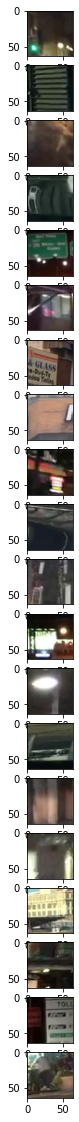

In [13]:
# hard negative samples visualisation
number_of_hard_neg_samples = len(hard_neg_samples)

fig, ax = plt.subplots(20,1,figsize=(2, 20))
for i in range(20):

    img = hard_neg_samples[np.random.randint(number_of_hard_neg_samples)]
    ax[i].imshow(img)

## Pyramid Window Sliding

In [163]:
def first_window_sliding(img, clf, scaler):
    # List of bounding box positions
    boxes_list = []
    pred_array = np.zeros((img.shape[0], img.shape[1]))
    ystart_ystop_scale = [(200, 450, 1),(200, 450, 2),(200, 450, 3),(200, 500, 4),(200, 500, 5)]
    step = 40
    proba = 0.05 # we want a high recall with this first classifier
    # Searching different size windows at different scales:
    for (ystart, ystop, scale) in ystart_ystop_scale:
        # Crop
        current_img = img[ystart:ystop, :, :]
        if scale != 1:
            current_img = cv2.resize(current_img, (np.int32(current_img.shape[1]/scale), np.int32(current_img.shape[0]/scale)))
        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        x_size = current_img.shape[1]
        y_size = current_img.shape[0]
        current_step = np.int32(step/scale)
        for xb in range(0, x_size-64, current_step):
            for yb in range(0, y_size-64, current_step):
                    
                xleft = np.int32(xb*scale)
                ytop = np.int32(yb*scale)

                # Extract the image patch
                try:
                    crop = current_img[ytop:ytop+64, xleft:xleft+64,:]
                    if crop.shape[0]!=64 or crop.shape[1]!=64:
                        crop = cv2.resize(crop, (64,64))
                except:
                    continue
                # compute features
                current_features = compute_features(crop)
                # Scale features and make a prediction
                current_features = scaler.transform([current_features]) 
                current_proba = clf.predict_proba(current_features)[0][1]
                xbox_left = np.int32(xleft*scale)
                ytop_draw = np.int32(ytop*scale)
                win_draw_x = np.int32(64*scale) 
                win_draw_y = win_draw_x
                if ytop_draw+ystart+win_draw_y > 500:
                    win_draw_y = 500 - ytop_draw - ystart
                # Append Detection Position to list 
                if current_proba >= proba:
                    boxes_list.append([xbox_left,ytop_draw+ystart,win_draw_x,win_draw_y])
                    pred_array[ytop_draw+ystart:ytop_draw+ystart+win_draw_y, xbox_left:xbox_left+win_draw_x] += current_proba

    return boxes_list, pred_array

In [164]:
i = 140
img = imread('./test/'+str(i).zfill(3)+'.jpg')
boxes_list, pred_array = first_window_sliding(img, clf, scaler)


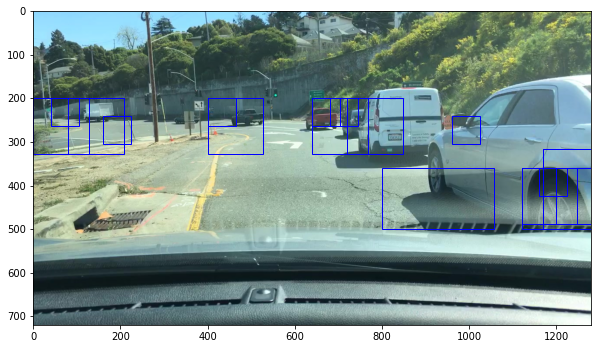

In [165]:
fig, ax = plt.subplots(figsize=(10, 8))
for x, y, dx, dy in boxes_list:


    rect = patches.Rectangle((x, y), dx, dy, edgecolor='b', facecolor='none')
    ax.add_patch(rect)
ax.imshow(img)


In [63]:
img.shape

(720, 1280, 3)

In [175]:
def window_sliding_advanced(img, boxes_list, clf, scaler):
    # List of bounding box positions
    pred_array = np.zeros((img.shape[0], img.shape[1]))
    scales = [0.7,1.1,1.3,2.5,3]
    step = 15
    proba = 0.2 # we want a very good precision this time
    new_boxes = []
    for box in boxes_list:
        xstart, xstop = max(0,box[0]-20),min(box[0]+box[2]+20,img.shape[1]) # we add a small offset to look further
        ystart, ystop = max(200,box[1]-20),min(box[1]+box[3]+20,500)
        for scale in scales:
            current_img = img[ystart:ystop, xstart:xstop, :]
            if scale != 1:
                try:
                    current_img = cv2.resize(current_img, (np.int32(current_img.shape[1]/scale), np.int32(current_img.shape[0]/scale)))
                except:
                    continue
            x_size = current_img.shape[1]
            y_size = current_img.shape[0]
            current_step = np.int32(step/scale)
            for xb in range(0, x_size-64, current_step ):
                for yb in range(0, y_size-64, current_step ):
                    xleft = np.int32(xb*scale)
                    ytop = np.int32(yb*scale)
                    # Extract the image patch
                    try:
                        crop = current_img[ytop:ytop+64, xleft:xleft+64,:]
                        if crop.shape[0]!=64 or crop.shape[1]!=64:
                            crop = cv2.resize(crop, (64,64))
                    except:
                        continue
                    # compute features
                    current_features = compute_features(crop)
                    # Scale features and make a prediction
                    current_features = scaler.transform([current_features]) 
                    current_proba = clf.predict_proba(current_features)[0][1]
                    if current_proba >= proba:
                        xbox_left = np.int32(xleft*scale)
                        ytop_draw = np.int32(ytop*scale)
                        win_draw = np.int32(64*scale)
                        # Append Detection Position to list 
                        new_boxes.append([xbox_left+xstart,ytop_draw+ystart,win_draw,win_draw])
                        pred_array[ytop_draw+ystart:ytop_draw+ystart+win_draw, xbox_left+xstart:xbox_left+xstart+win_draw] += 1
    return new_boxes, pred_array

In [176]:
test = non_max_suppression(np.array(boxes_list), overlapThresh=0.1)
boxes_list2, pred_array2 = window_sliding_advanced(img, test, clf, scaler)

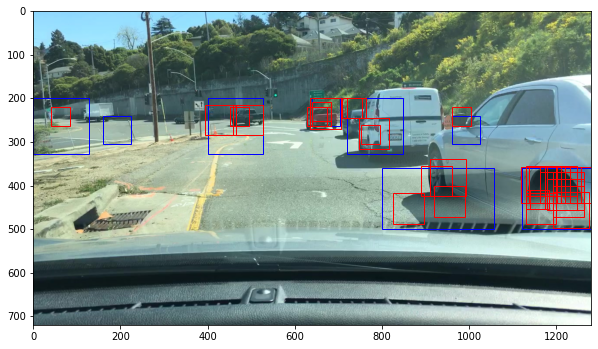

In [177]:
fig, ax = plt.subplots(figsize=(10, 8))
for x, y, dx, dy in test:
    rect = patches.Rectangle((x, y), dx, dy, edgecolor='b', facecolor='none')
    ax.add_patch(rect)
for x, y, dx, dy in boxes_list2:
    rect = patches.Rectangle((x, y), dx, dy, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
ax.imshow(img)

In [19]:
def bounding_boxes_to_mask(bounding_boxes, H, W):
    
    """
    Converts set of bounding boxes to a binary mask
    """

    mask = np.zeros((H, W))
    for x, y, dx, dy in bounding_boxes:
        mask[y:y+dy, x:x+dx] = 1

    return mask

def run_length_encoding(mask):

    """
    Produces run length encoding for a given binary mask
    """
    
    # find mask non-zeros in flattened representation
    non_zeros = np.nonzero(mask.flatten())[0]
    padded = np.pad(non_zeros, pad_width=1, mode='edge')
    
    # find start and end points of non-zeros runs
    limits = (padded[1:] - padded[:-1]) != 1
    starts = non_zeros[limits[:-1]]
    ends = non_zeros[limits[1:]]
    lengths = ends - starts + 1

    return ' '.join(['%d %d' % (s, l) for s, l in zip(starts, lengths)])

In [20]:
from skimage.io import imread
import copy 

images_list = os.listdir('test/')
submission_df = pd.read_csv('sample_submission.csv')
submission_df = submission_df.drop(index = [0])
for img_path in tqdm(images_list, position=0):
    img = imread('./test/'+img_path)

    (bboxes, pred_array) = window_sliding(img)
    # non max suppresion
    new_boxes = box_otsu(pred_array>1)

    new_boxes = non_max_suppression(np.array(new_boxes))

    predictions = np.array(new_boxes).ravel()

    final_pred = ' '.join(predictions.astype(str))

    line_to_add = pd.DataFrame([['test/'+img_path, final_pred]], columns = submission_df.columns)
    submission_df  = pd.concat([submission_df, line_to_add], axis = 0)

verif_df = copy.deepcopy(submission_df)
# pre saving in order not to loose everything    
submission_df.to_csv('final_predictions.csv', index=False)
# convert prediction to the right format
preds = []
for i in range(submission_df.shape[0]):

    bbs = list(map(int, submission_df.iloc[i].Predicted.split(" ")))
    bbs = np.array_split(bbs, len(bbs) / 4)

    mask = bounding_boxes_to_mask(bbs, 720, 1280)
    pred = run_length_encoding(mask)
    preds.append(pred)

submission_df.Predicted = preds

submission_df.to_csv('final_predictions.csv', index=False)

  0%|          | 0/202 [00:00<?, ?it/s]


NameError: name 'window_sliding' is not defined

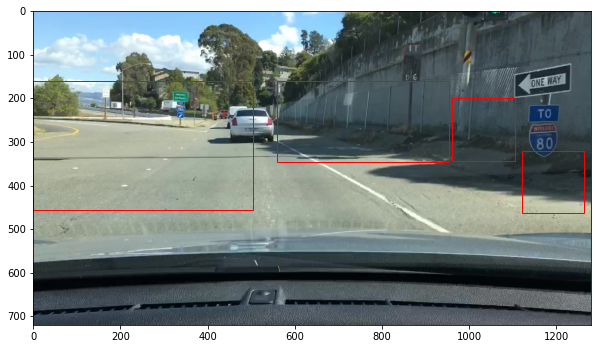

In [ ]:
images_list = os.listdir('test/')


img = imread('./test/'+images_list[20])

(bboxes, pred_array) = window_sliding(img)
# filter boxes
#bboxes = filter_boxes(bboxes,pred_array)

# non max suppresion
new_boxes = box_otsu(pred_array>1)

new_boxes = non_max_suppression(np.array(new_boxes))

fig, ax = plt.subplots(figsize=(10, 8))

for x, y, dx, dy in new_boxes:

    rect = patches.Rectangle((x, y), dx, dy, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

ax.imshow(img)